In [1]:
import os
import numpy as np
import wfdb
import cv2 as cv2
from wfdb import processing
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signals dsp
from scipy.signal import butter, lfilter, iirfilter
from IPython.display import display
from scipy.signal import freqz
from scipy import signal

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Pytorch
import torch

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization, Activation,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D,
    Conv2D, MaxPooling2D, ZeroPadding2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model

In [2]:
mitdb_path = r"./Dataset/mitdb"

In [7]:
record = wfdb.rdsamp(mitdb_path + '/124')
annotation = wfdb.rdann(mitdb_path+ '/124', 'atr')

In [4]:
if os.path.isdir(mitdb_path):
  print('You already have the data.')

You already have the data.


In [5]:
# def butter_lowpass(cutoff, fs, order=5):
#   nyq = 0.5 * fs
#   normal_cutoff = cutoff / nyq
#   b, a = butter(order, normal_cutoff, btype='low')
#   return b, a

# def butter_lowpass_filter(data, lowcut, fs, order=5):
#   b, a = butter_lowpass(lowcut, fs, order=order)
#   y = lfilter(b, a, data, axis=0)
#   return y
# def normalized_1(sig):
#   normalized_sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))
#   return normalized_sig

In [6]:
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
# I = record[0][:, 0]
# II = record[0][:, 1]


# filteredSig_I = butter_lowpass_filter(I, 0.5, 300, 2)
# filteredSig_I = normalized_1(filteredSig_I)

# filteredSig_II = butter_lowpass_filter(II, 0.5, 300, 2)
# filteredSig_II = normalized_1(filteredSig_II)

# ax[0, 0].plot(I, label="Lead I (Raw)", color='r')
# ax[0, 1].plot(filteredSig_I, label="Lead I (Filtered)", color='g')
# ax[1, 0].plot(II, label="Lead II (Raw)", color='b')
# ax[1, 1].plot(filteredSig_II, label="Lead II (Filtered)", color='purple')

# ax[0, 0].set_ylabel('Lead I')
# ax[1, 0].set_ylabel('Lead II')
# ax[1, 0].set_xlabel('Datapoints')
# ax[1, 1].set_xlabel('Datapoints')

# ax[0, 0].legend()
# ax[0, 1].legend()
# ax[1, 0].legend()
# ax[1, 1].legend()

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order,[low, high], btype='bandpass')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data,axis=0)
  return y

def iir_bandpass(lowcut, highcut, fs, order=5, ftype='butter'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = iirfilter(order, [low, high], btype='band', ftype=ftype, fs=fs)
    return b, a

def iir_bandpass_filter(data, lowcut, highcut, fs, order=5, ftype='butter'):
    b, a = iir_bandpass(lowcut, highcut, fs, order, ftype)
    y = lfilter(b, a, data, axis=0)
    return y

def normalized(sig):
  normalized_sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))
  return normalized_sig

def DynamicSegmentation(peaksIndecies,signal):
  beats = [[]]
  beats.remove([])
  for i in range(1,len(peaksIndecies)-1):
      RRPrev = peaksIndecies[i] - peaksIndecies[i-1]
      RRNext = peaksIndecies[i+1] - peaksIndecies[i]
      RRMax = max(RRPrev, RRNext)
      start = peaksIndecies[i]- int((1/3.0)*RRMax)
      end = peaksIndecies[i] + int((2 / 3.0 )* RRMax)
      beats.append(signal[start:end])
  return beats


def resampling(beats,samprate):
  resampled = [[]]
  resampled.remove([])
  for i in beats:
      resampled.append(list(signal.resample(i,samprate)))
  return resampled

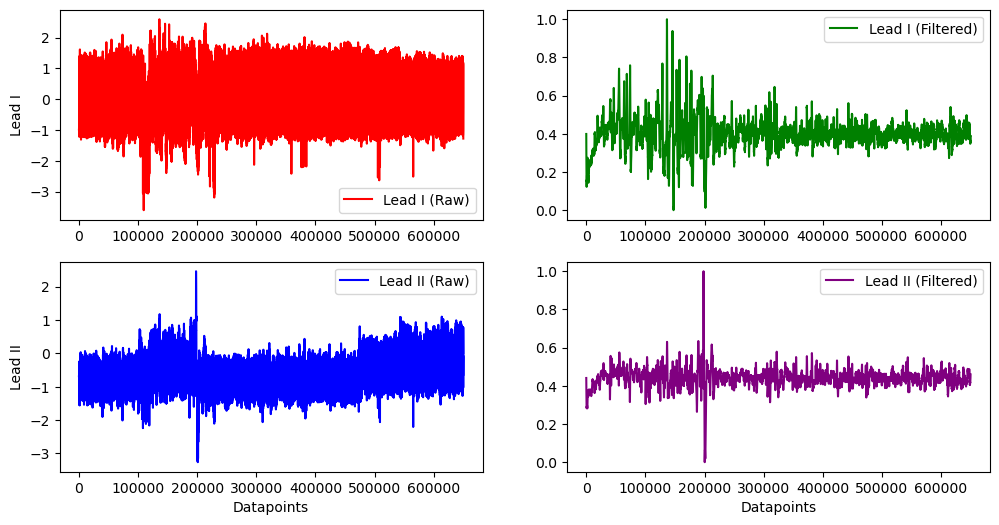

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
I = record[0][:, 0]
II = record[0][:, 1]


filteredSig_I = iir_bandpass_filter(I, 0.35, 40, 300, 2)
filteredSig_I = normalized(filteredSig_I)

filteredSig_II = iir_bandpass_filter(II, 0.35, 40, 300, 2)
filteredSig_II = normalized(filteredSig_II)

ax[0, 0].plot(I, label="Lead I (Raw)", color='r')
ax[0, 1].plot(filteredSig_I, label="Lead I (Filtered)", color='g')
ax[1, 0].plot(II, label="Lead II (Raw)", color='b')
ax[1, 1].plot(filteredSig_II, label="Lead II (Filtered)", color='purple')

ax[0, 0].set_ylabel('Lead I')
ax[1, 0].set_ylabel('Lead II')
ax[1, 0].set_xlabel('Datapoints')
ax[1, 1].set_xlabel('Datapoints')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

In [29]:
def PreProcessing(signal,fs = 360, datasetinds = None):

  filteredSig = iir_bandpass_filter(signal, 0.35, 40, 360, 2)
  filteredSig = normalized(filteredSig)

  if datasetinds == None:
      qrs_inds = processing.xqrs_detect(sig=filteredSig[:, 0], fs=fs)
      beats = DynamicSegmentation(qrs_inds,filteredSig)
  else:
      beats = DynamicSegmentation(datasetinds,filteredSig)
  beats = resampling(beats,24)

  return beats

In [30]:
def filterAnnotation(annotation):
  classes = ['N', 'L', 'R', 'A', 'V', '/']
  annotations = []
  RPeaksInds = []
  for ann in range(len(annotation.symbol)):
      if annotation.symbol[ann] in classes:
          annotations.append(annotation.symbol[ann])
          RPeaksInds.append(annotation.sample[ann])
  return annotations,RPeaksInds

def AppendBeatsOfSignalToFile(beats,filePath):
  if not os.path.exists(filePath):
    open(filePath, "w").close()

  f = open(filePath,"a")
  for i in range(len(beats)):
      for j in range(len(beats[i])):
          f.write(str(beats[i][j][0])+'|')
      f.write('\n')
  f.close()
  return

def WriteAnnotationSymbolToFile(annotationSymbol,filepath):
  if not os.path.exists(filepath):
      open(filepath, "w").close()
  f = open(filepath,"a")
  for i in range(1,len(annotationSymbol)-1):
      f.write(str(annotationSymbol[i])+'\n')
  f.close()
  return

def PrepareFiles(filenames , directory):
  print('writing files has been started')
  for i in range(0,len(filenames)):
      print('Now in record '+str(filenames[i]))
      annotation = wfdb.rdann(r'./Dataset/mitdb/' + str(filenames[i]), 'atr')
      annotation.symbol, annotation.sample = filterAnnotation(annotation)
      sig, fields = wfdb.rdsamp(r'./Dataset/mitdb/' + str(filenames[i]), channels=[0], sampfrom=0, sampto=None)
      beats = PreProcessing(sig,fields['fs'],annotation.sample)

      AppendBeatsOfSignalToFile(beats,directory+'mitdbAllBeats.txt')
      WriteAnnotationSymbolToFile(annotation.symbol,directory+'mitdbAllAnnotationsSymbols.txt')
  print('done')



def ClusteringBeatsInFiles(BeatsFilePath,AnnotationFilePath , directory):
  classes = ['N', 'L', 'R', 'A', 'V', '/']
  bf = open(BeatsFilePath,"r")
  annf = open(AnnotationFilePath,"r")
  beats = bf.readlines()
  annotations = annf.readlines()
  print(len(beats))
  print(len(annotations))
  b = {}
  files = {'N':'Normal',
            'L':'Left_bundle_branch_block',
            'R':'Right_bundle_branch_block',
            'A':'Atrial_premature',
            'V':'Premature_ventricular_contraction',
            '/':'Paced'}
  for i in classes:
      b[i] = []
  for i in range(len(beats)):
      b[annotations[i].split('\n')[0]].append(beats[i])
  for ann , bts in b.items():
      f = open(directory+files[ann]+'.txt' , "w")
      f.writelines(bts)
      f.close()

In [31]:
all_records = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
             111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
             122, 123, 124, 200, 201, 202, 203, 205, 207, 208,
             209, 210, 212, 213, 214, 215, 217, 219, 220, 221,
             222, 223, 228, 230, 231, 232, 233, 234]

train_records = [101,102, 104, 106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]
test_records = [100,103,105,107, 111,113,117,121,123,200,202,210,212,213,214, 217,219,221,222,228,231,232,233,234]

In [32]:
data_dir = r'./Data_00/'
train_dir = data_dir + r'/Train/'
test_dir = data_dir + r'/Test/'
PrepareFiles(train_records,train_dir)
PrepareFiles(test_records,test_dir)

ClusteringBeatsInFiles(train_dir+'mitdbAllBeats.txt' , train_dir+'mitdbAllAnnotationsSymbols.txt',train_dir)
ClusteringBeatsInFiles(test_dir+'mitdbAllBeats.txt' , test_dir+'mitdbAllAnnotationsSymbols.txt',test_dir)

writing files has been started
Now in record 101
Now in record 102
Now in record 104
Now in record 106
Now in record 108
Now in record 109
Now in record 112
Now in record 114
Now in record 115
Now in record 116
Now in record 118
Now in record 119
Now in record 122
Now in record 124
Now in record 201
Now in record 203
Now in record 205
Now in record 207
Now in record 208
Now in record 209
Now in record 215
Now in record 220
Now in record 223
Now in record 230
done
writing files has been started
Now in record 100
Now in record 103
Now in record 105
Now in record 107
Now in record 111
Now in record 113
Now in record 117
Now in record 121
Now in record 123
Now in record 200
Now in record 202
Now in record 210
Now in record 212
Now in record 213
Now in record 214
Now in record 217
Now in record 219
Now in record 221
Now in record 222
Now in record 228
Now in record 231
Now in record 232
Now in record 233
Now in record 234
done
1187010
1187010
1166858
1166858


In [33]:
def One_Hot_Encoded_Y(classNumber,NumberOfClasses,NumberOfSamples):
  if NumberOfSamples == 0:
    Y = np.empty((0,NumberOfClasses))
    return Y
  Yi = np.zeros(NumberOfClasses)
  Yi[classNumber] = 1
  Y = np.vstack([Yi]*NumberOfSamples)
  return Y
# Read Class from Text file and return X , Y
def ReadClassData(path,ZeroBased_classNumber,NumOfClasses):
  Data = open(path, "r").readlines()
  X = []
  for i in Data:
      row = i.split('|')
      row.remove('\n')
      row = list(map(float, row))
      X.append(row)
  X = np.array(X)
  if X.shape[0] == 0:
    X = np.empty((0,300))
  Y = One_Hot_Encoded_Y(ZeroBased_classNumber,NumOfClasses,X.shape[0])
  return X,Y

# concatenate classes training data & testing data and make Y for this category
def Prepare_Category(ClassesTrainData,ClassesTestData, classNumber,NumberOfCategories,MultiClassCategory=True):
  if MultiClassCategory:

    Ncat_X_train= np.concatenate(ClassesTrainData, axis=0)
    Ncat_X_test = np.concatenate(ClassesTestData, axis=0)
  else:
    print('category of one class')
    Ncat_X_train = ClassesTrainData
    Ncat_X_test = ClassesTestData

  Ncat_Y_train = One_Hot_Encoded_Y(classNumber,NumberOfCategories,Ncat_X_train.shape[0])


  Ncat_Y_test = One_Hot_Encoded_Y(classNumber,NumberOfCategories,Ncat_X_test.shape[0])

  #Ncat_X_train,Ncat_Y_train = shuffle(Ncat_X_train,Ncat_Y_train)
  #Ncat_X_test , Ncat_Y_test = shuffle(Ncat_X_test , Ncat_Y_test)
  return Ncat_X_train , Ncat_X_test , Ncat_Y_train , Ncat_Y_test

def Model_Y(NumberOfSamplesEachClass = []):
  NumberOfClasses = len(NumberOfSamplesEachClass)
  Ys = []
  for i in range(NumberOfClasses):
      Ys.append(One_Hot_Encoded_Y(i,NumberOfClasses,NumberOfSamplesEachClass[i]))
  Ys = tuple(Ys)
  Y = np.concatenate(Ys,axis=0)
  return Y


In [34]:
files = {'N':'Normal',
          'L':'Left_bundle_branch_block',
          'R':'Right_bundle_branch_block',
          'A':'Atrial_premature',
          'V':'Premature_ventricular_contraction',
          '/':'Paced'}
directory_train   = './Data_00/Train/'
directory_test    = './Data_00/Test/'

shuff = True
NumOfClasses = 6

path = directory_train + files['N'] + '.txt'
XN_train , YN_train = ReadClassData(path,0,NumOfClasses)
path = directory_test + files['N'] + '.txt'
XN_test , YN_test = ReadClassData(path,0,NumOfClasses)


path = directory_train + files['L'] + '.txt'
XL_train , YL_train = ReadClassData(path,1,NumOfClasses)
path = directory_test + files['L'] + '.txt'
XL_test , YL_test = ReadClassData(path,1,NumOfClasses)


path = directory_train + files['R'] + '.txt'
XR_train , YR_train = ReadClassData(path,2,NumOfClasses)
path = directory_test + files['R'] + '.txt'
XR_test , YR_test = ReadClassData(path,2,NumOfClasses)

path = directory_train + files['A'] + '.txt'
XA_train , YA_train = ReadClassData(path,3,NumOfClasses)
path = directory_test + files['A'] + '.txt'
XA_test , YA_test = ReadClassData(path,3,NumOfClasses)


path = directory_train + files['V'] + '.txt'
XV_train , YV_train = ReadClassData(path,4,NumOfClasses)
path = directory_test + files['V'] + '.txt'
XV_test , YV_test = ReadClassData(path,4,NumOfClasses)


path = directory_train + files['/'] + '.txt'
XP_train , YP_train = ReadClassData(path,5,NumOfClasses)
path = directory_test + files['/'] + '.txt'
XP_test , YP_test = ReadClassData(path,5,NumOfClasses)

In [35]:
X_TRAIN= np.concatenate((XA_train,XL_train,XN_train,XR_train,XV_train,XP_train), axis=0)
Y_TRAIN= np.concatenate((YA_train,YL_train,YN_train,YR_train,YV_train,YP_train), axis=0)

X_TEST= np.concatenate((XA_test,XL_test,XN_test,XR_test,XV_test,XP_test), axis=0)
Y_TEST= np.concatenate((YA_test,YL_test,YN_test,YR_test,YV_test,YP_test), axis=0)

X_train , Y_train = shuffle(X_TRAIN , Y_TRAIN)
X_test,Y_test = shuffle( X_TEST,Y_TEST)
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

In [38]:
def ECG_MODEL(nclass = 6):
    inp = Input(shape=(24, 1))
    lay = Conv1D(3, kernel_size=7, activation='relu', padding="same")(inp)
    lay = MaxPooling1D(pool_size=2)(lay)


    lay = Conv1D(1, kernel_size=1, activation='relu', padding="same")(lay)

    lay = Conv1D(3, kernel_size=7, activation='relu', padding="same")(lay)
    lay = MaxPooling1D(pool_size=3)(lay)

    flat = Flatten()(lay)

    dense_1 = Dense(21, activation='relu')(flat)

    dense_2 = Dense(nclass, activation='softmax')(dense_1)

    model = Model(inputs=inp, outputs=dense_2)
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss=CategoricalCrossentropy(),
                  metrics=['acc'])
    model.summary()
    return model

In [39]:
model = ECG_MODEL()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 24, 3)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 12, 3)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 21)             │           273 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457 (1.79 KB)

 Trainable params: 457 (1.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Tham số huấn luyện
epochs = 200
batch_size = 32

# Huấn luyện mô hình
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/200
37095/37095 ━━━━━━━━━━━━━━━━━━━━ 442s 12ms/step - acc: 0.7104 - loss: 1.1215 - val_acc: 0.6911 - val_loss: 1.1134
Epoch 2/200
37095/37095 ━━━━━━━━━━━━━━━━━━━━ 407s 11ms/step - acc: 0.7105 - loss: 1.0411 - val_acc: 0.6911 - val_loss: 1.1142
Epoch 3/200
37095/37095 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7103 - loss: 1.0415

In [19]:
"""Model Construction"""

def Build_Confusion_Matrix(y_test,y_pred,num_of_classes):
  confusion_matrix = np.zeros((num_of_classes,num_of_classes))
  for i in range(len(y_test)):
    confusion_matrix[y_test[i],y_pred[i]]+=1
  return confusion_matrix

def Calculate_Accuracy(confusion_matrix):
  acc = (np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix))*100
  accuracies = []
  for i in range(len(confusion_matrix)):
    class_count = confusion_matrix[i,i]
    if class_count == 0:
      accuracies.append(0)
    else:
      ac = (confusion_matrix[i,i]/np.sum(confusion_matrix[i,:]))*100
      accuracies.append(ac)
  print(accuracies)
  average_accuracy = np.average(accuracies)
  print('Average Accuracy', average_accuracy )
  print('Overall Accuracy',acc)

  return acc , average_accuracy

def Evaluate(y_test,y_pred,num_of_classes):
  confusion_matrix = Build_Confusion_Matrix(y_test,y_pred,num_of_classes)
  confusion_matrix = np.int64(confusion_matrix)
  print(confusion_matrix)
  return Calculate_Accuracy(confusion_matrix)

def Predict_and_Evaluate(model,X_test,Y_test,NumOfClasses):
  Y_predict = model.predict(X_test)
  inds = np.argmax(Y_test,axis=1)
  pred = np.argmax(Y_predict,axis=1)
  accuracy = sum([np.argmax(Y_predict[i])==np.argmax(Y_test[i]) for i in range(len(Y_test))])/len(Y_test)
  print(accuracy)
  return Evaluate( inds , pred , NumOfClasses)


def Plot_Confusion_Matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [20]:
num_of_classes = 6

In [21]:
accuracy, avg_accuracy = Predict_and_Evaluate(model, X_test, Y_test, NumOfClasses)

34807/34807 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
0.701702879911368
[[706531   2612  10844   2647  37266   9855]
 [ 67942   2056   5127     18   3202   8217]
 [ 65183    190   2918    324   1681   2616]
 [ 20651    179   9195    126   1364   4920]
 [ 10992   1292   3910   1350  50462   4213]
 [  9779    283   2519    846  43032  19477]]
[91.78647751557314, 2.375176174302812, 4.002084704849682, 0.345821325648415, 69.87357897506197, 25.64923093131058]
Average Accuracy 32.33872827112443
Overall Accuracy 70.1702879911368


In [22]:
Y_predict = model.predict(X_test)
y_pred = np.argmax(Y_predict, axis=1)
y_test = np.argmax(Y_test, axis=1)

34807/34807 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step


In [23]:
conf_matrix = Build_Confusion_Matrix(y_test, y_pred, NumOfClasses)

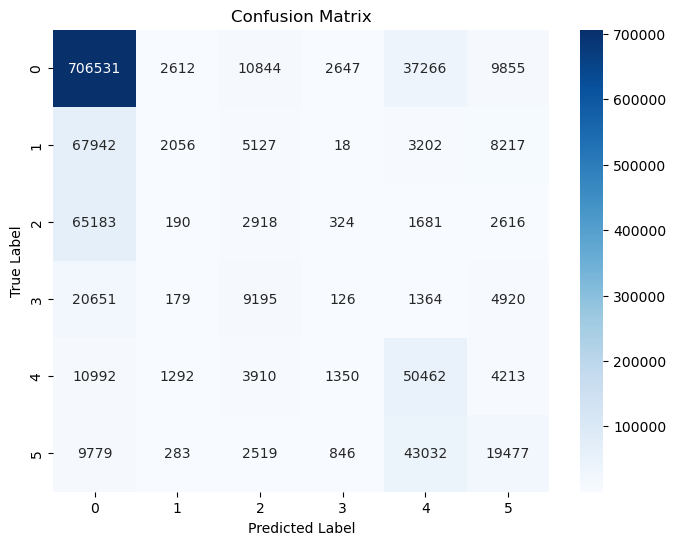

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=range(NumOfClasses), yticklabels=range(NumOfClasses))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("./Output_03/confusion_matrix.png")  # Lưu hình ảnh
plt.show()

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

34807/34807 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - acc: 0.7012 - loss: 2.6409


In [ ]:
model.save(r"./Output_03/ecg_model.h5")

np.savez(r"./Output_03/model_results.npz",
         confusion_matrix=conf_matrix,
         accuracy=test_accuracy,
         loss=test_loss)

with open(r"./Output_03/model_metrics.pkl", "wb") as f:
    pickle.dump({"confusion_matrix": conf_matrix, "accuracy": test_accuracy, "loss": test_loss}, f)
